#NFL Player predictions

For my capstone, I will be using past NFL season's player data/statistics to predict a Player's cumulative Fantasy Football points for an entire season. Fantasy Points are a cumulative total of a players in game statistics summed up into 1 number. The statistics that factor into Fantasy Points include:

-Yards (rushing, receiving, and passing)

-Catches

-Touchdowns

-Fumbles



I will be using the most commonly used Fantasy Football scoring system: Half PPR (points per reception). This means players will get 0.5 points per reception.


Things to note for the models I will be building:

-Because rookies and players with little to no previous data are harder to predict in this model, I will only be attempting to predict players with a minimum of 50 snaps from 1 season prior to the predicted season.

-Because the NFL has added an extra game per season starting in 2021, I will be focusing on data up to 2020 to make the maximum number of games played equal between all seasons

I will be attempting to predict the 4 major offensive positions in Fantasy football, using a linear Regression and a Random Forrest model for each position, and then selecting the best model based on the Mean Absolute Error for each model. The mean absolute error number will represent on average how far the model was off of the season total. By diving this number by the number of games played by a player in a season (16), we can see on average how off our model was on a weekly basis.

The 4 positions I will be modeling:

-QB: Quarterback

-WR: Wide Receiver

-RB: Runningback

-TE: Tight End

In [1]:
#imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import warnings
import seaborn as sns
import requests
from io import BytesIO
import nflfastpy as nfl

warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

sns.set_style('whitegrid') # setting style for visualizations

In [2]:
#reading already cleaned dataframe for player data from past seasons 2000-2019, as well as some combine data
#combine data may be helpful to predict rookies, but I will not be predicting rookies in this model because of the lack of past data
df = pd.read_csv('data_cleaned.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124222 entries, 0 to 124221
Data columns (total 38 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   0                               124222 non-null  int64  
 1   player_id                       124222 non-null  int64  
 2   tm                              124222 non-null  object 
 3   pos                             124222 non-null  object 
 4   player                          124222 non-null  object 
 5   season                          124222 non-null  int64  
 6   week                            124222 non-null  int64  
 7   NFL_draft_year                  92006 non-null   float64
 8   NFL_draft_round                 92006 non-null   float64
 9   NFL_draft_rank                  92006 non-null   float64
 10  height_inches                   124191 non-null  float64
 11  weight_pounds                   124191 non-null  float64
 12  forty_yd        

In [3]:
df.head()

,0,player_id,tm,pos,player,season,week,NFL_draft_year,NFL_draft_round,NFL_draft_rank,height_inches,weight_pounds,forty_yd,three_cone,bench,broad_jump,combine_height,shuttle,vertical,offensive_snapcount,offensive_snapcount_percentage,passing_int,passing_rating,passing_yds,passing_two_pt_md,passing_td,passing_att,receiving_yds,receiving_td,receiving_rec,receiving_tar,rushing_att,rushing_td,rushing_yds,fumbles_lost,half_ppr_fantasy_points,ppr_fantasy_points,standard_fantasy_points
0,0,2755,NYG,WR,Rueben Randle,2014,9,2012.0,2.0,63.0,74.0,208.0,4.55,6.99,15.0,121.0,75.0,4.36,31.0,72.0,95.0,0.0,0.0,0.0,0.0,0.0,0.0,49.0,0.0,4.0,11.0,0.0,0.0,0.0,0.0,6.9,8.9,4.9
1,1,2755,NYG,WR,Rueben Randle,2014,10,2012.0,2.0,63.0,74.0,208.0,4.55,6.99,15.0,121.0,75.0,4.36,31.0,66.0,97.0,0.0,0.0,0.0,0.0,0.0,0.0,39.0,0.0,5.0,10.0,0.0,0.0,0.0,0.0,6.4,8.9,3.9
2,2,2755,NYG,WR,Rueben Randle,2014,11,2012.0,2.0,63.0,74.0,208.0,4.55,6.99,15.0,121.0,75.0,4.36,31.0,55.0,79.0,0.0,0.0,0.0,0.0,0.0,0.0,112.0,0.0,7.0,15.0,0.0,0.0,0.0,0.0,14.7,18.2,11.2
3,3,2755,NYG,WR,Rueben Randle,2014,12,2012.0,2.0,63.0,74.0,208.0,4.55,6.99,15.0,121.0,75.0,4.36,31.0,69.0,92.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,5.1,6.6,3.6
4,4,2755,NYG,WR,Rueben Randle,2014,13,2012.0,2.0,63.0,74.0,208.0,4.55,6.99,15.0,121.0,75.0,4.36,31.0,45.0,61.0,0.0,0.0,0.0,0.0,0.0,0.0,52.0,0.0,3.0,4.0,0.0,0.0,0.0,0.0,6.7,8.2,5.2


In [4]:
#Removing first column that has no use
df = df.iloc[:,1:]
df.head()

,player_id,tm,pos,player,season,week,NFL_draft_year,NFL_draft_round,NFL_draft_rank,height_inches,weight_pounds,forty_yd,three_cone,bench,broad_jump,combine_height,shuttle,vertical,offensive_snapcount,offensive_snapcount_percentage,passing_int,passing_rating,passing_yds,passing_two_pt_md,passing_td,passing_att,receiving_yds,receiving_td,receiving_rec,receiving_tar,rushing_att,rushing_td,rushing_yds,fumbles_lost,half_ppr_fantasy_points,ppr_fantasy_points,standard_fantasy_points
0,2755,NYG,WR,Rueben Randle,2014,9,2012.0,2.0,63.0,74.0,208.0,4.55,6.99,15.0,121.0,75.0,4.36,31.0,72.0,95.0,0.0,0.0,0.0,0.0,0.0,0.0,49.0,0.0,4.0,11.0,0.0,0.0,0.0,0.0,6.9,8.9,4.9
1,2755,NYG,WR,Rueben Randle,2014,10,2012.0,2.0,63.0,74.0,208.0,4.55,6.99,15.0,121.0,75.0,4.36,31.0,66.0,97.0,0.0,0.0,0.0,0.0,0.0,0.0,39.0,0.0,5.0,10.0,0.0,0.0,0.0,0.0,6.4,8.9,3.9
2,2755,NYG,WR,Rueben Randle,2014,11,2012.0,2.0,63.0,74.0,208.0,4.55,6.99,15.0,121.0,75.0,4.36,31.0,55.0,79.0,0.0,0.0,0.0,0.0,0.0,0.0,112.0,0.0,7.0,15.0,0.0,0.0,0.0,0.0,14.7,18.2,11.2
3,2755,NYG,WR,Rueben Randle,2014,12,2012.0,2.0,63.0,74.0,208.0,4.55,6.99,15.0,121.0,75.0,4.36,31.0,69.0,92.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,5.1,6.6,3.6
4,2755,NYG,WR,Rueben Randle,2014,13,2012.0,2.0,63.0,74.0,208.0,4.55,6.99,15.0,121.0,75.0,4.36,31.0,45.0,61.0,0.0,0.0,0.0,0.0,0.0,0.0,52.0,0.0,3.0,4.0,0.0,0.0,0.0,0.0,6.7,8.2,5.2


In [5]:
#dataframe for 2020 player statistics
#will use half ppr fantasy points from this df to compare how well my model actually did 
df2020 = pd.read_csv('yearly/2020.csv')

#creating a variable for half ppr Fantasy points
df2020['actual_2020'] = df2020['FantasyPoints'] + df2020['Rec']*0.5


df2020.head()

,Player,Tm,Pos,Age,G,GS,Tgt,Rec,PassingYds,PassingTD,PassingAtt,RushingYds,RushingTD,RushingAtt,ReceivingYds,ReceivingTD,FantasyPoints,Int,Fumbles,FumblesLost,actual_2020
0,Derrick Henry,TEN,RB,26,16,16,31,19,0,0,0,2027,17,378,114,0,314.0,0,3,2,323.5
1,Alvin Kamara,NOR,RB,25,15,10,107,83,0,0,0,932,16,187,756,5,295.0,0,1,0,336.5
2,Dalvin Cook,MIN,RB,25,14,14,54,44,0,0,0,1557,16,312,361,1,294.0,0,5,3,316.0
3,Travis Kelce,KAN,TE,31,15,15,145,105,4,0,2,0,0,0,1416,11,208.0,0,1,1,260.5
4,Davante Adams,GNB,WR,28,14,14,149,115,0,0,0,0,0,0,1374,18,243.0,0,1,1,300.5


In [6]:
#renaming 'Player' column to match 'player' column in original df
df2020.rename(columns = {'Player' : 'player'}, inplace = True)

#sorting values by Half PPR fantasy points, the target variable i am looking to predict in my model
df2020.sort_values(by = 'actual_2020', ascending = False, inplace = True)

#Dropping all columns except player name and Half PPR fantasy points
df2020_half_ppr = df2020.drop(columns = ['Tm','Pos','Age','G','GS','Tgt','Rec','PassingYds','PassingTD','PassingAtt','RushingYds','RushingTD','RushingAtt','ReceivingYds','ReceivingTD','FantasyPoints','Int','Fumbles','FumblesLost'])

df2020.head()

,player,Tm,Pos,Age,G,GS,Tgt,Rec,PassingYds,PassingTD,PassingAtt,RushingYds,RushingTD,RushingAtt,ReceivingYds,ReceivingTD,FantasyPoints,Int,Fumbles,FumblesLost,actual_2020
6,Josh Allen,BUF,QB,24,16,16,1,1,4544,37,572,421,8,102,12,1,395.0,10,9,6,395.5
7,Aaron Rodgers,GNB,QB,37,16,16,1,1,4299,48,526,149,3,38,-6,0,382.0,5,4,2,382.5
8,Kyler Murray,ARI,QB,23,16,16,0,0,3971,26,558,819,11,133,0,0,379.0,12,9,4,379.0
9,Patrick Mahomes,KAN,QB,25,15,15,2,0,4740,38,588,308,2,62,0,0,374.0,6,5,2,374.0
10,Deshaun Watson,HOU,QB,25,16,16,0,0,4823,33,544,444,3,90,0,0,369.0,7,8,3,369.0


In [7]:
df2020.columns

Index(['player', 'Tm', 'Pos', 'Age', 'G', 'GS', 'Tgt', 'Rec', 'PassingYds',
       'PassingTD', 'PassingAtt', 'RushingYds', 'RushingTD', 'RushingAtt',
       'ReceivingYds', 'ReceivingTD', 'FantasyPoints', 'Int', 'Fumbles',
       'FumblesLost', 'actual_2020'],
      dtype='object')

In [8]:
#Creating seperate 2020 dataframes per position

rb_df2020 = df2020[df2020['Pos'] == 'RB']
wr_df2020 = df2020[df2020['Pos'] == 'WR']
te_df2020 = df2020[df2020['Pos'] == 'TE']
qb_df2020 = df2020[df2020['Pos'] == 'QB']
flex_df2020 = df2020[df2020['Pos'] != 'QB']

rb_df2020.head()

,player,Tm,Pos,Age,G,GS,Tgt,Rec,PassingYds,PassingTD,PassingAtt,RushingYds,RushingTD,RushingAtt,ReceivingYds,ReceivingTD,FantasyPoints,Int,Fumbles,FumblesLost,actual_2020
1,Alvin Kamara,NOR,RB,25,15,10,107,83,0,0,0,932,16,187,756,5,295.0,0,1,0,336.5
0,Derrick Henry,TEN,RB,26,16,16,31,19,0,0,0,2027,17,378,114,0,314.0,0,3,2,323.5
2,Dalvin Cook,MIN,RB,25,14,14,54,44,0,0,0,1557,16,312,361,1,294.0,0,5,3,316.0
14,David Montgomery,CHI,RB,23,15,14,68,54,0,0,0,1070,8,247,438,2,211.0,0,1,1,238.0
12,Aaron Jones,GNB,RB,26,14,14,63,47,0,0,0,1104,9,201,355,2,212.0,0,2,0,235.5


In [9]:
#confirming seasons in original df start at 2000 and end in 2019
print(df.season.min(), df.season.max())

2000 2019


In [10]:
#grouping players by ID, team, position, and season
#useing agg to get the sum of some coloumns and the mean of other columns

df = df.groupby(['player_id', 'tm', 'player', 'pos', 'season'], as_index = False)\
    .agg({
    'offensive_snapcount' : np.sum,
    'offensive_snapcount_percentage' : np.mean,
    'passing_rating' : np.mean,
    'passing_yds' : np.sum,
    'passing_td' : np.sum,
    'passing_att' : np.sum,
    'receiving_yds' : np.sum,
    'receiving_td' : np.sum,
    'receiving_rec' : np.sum,
    'receiving_tar' : np.sum,
    'rushing_yds' : np.sum,
    'rushing_att' : np.sum,
    'rushing_td' : np.sum,
    'half_ppr_fantasy_points' : np.sum,
    'ppr_fantasy_points' : np.sum,
    'standard_fantasy_points' : np.sum
    
})

array([[<AxesSubplot:title={'center':'player_id'}>,
        <AxesSubplot:title={'center':'season'}>,
        <AxesSubplot:title={'center':'offensive_snapcount'}>,
        <AxesSubplot:title={'center':'offensive_snapcount_percentage'}>],
       [<AxesSubplot:title={'center':'passing_rating'}>,
        <AxesSubplot:title={'center':'passing_yds'}>,
        <AxesSubplot:title={'center':'passing_td'}>,
        <AxesSubplot:title={'center':'passing_att'}>],
       [<AxesSubplot:title={'center':'receiving_yds'}>,
        <AxesSubplot:title={'center':'receiving_td'}>,
        <AxesSubplot:title={'center':'receiving_rec'}>,
        <AxesSubplot:title={'center':'receiving_tar'}>],
       [<AxesSubplot:title={'center':'rushing_yds'}>,
        <AxesSubplot:title={'center':'rushing_att'}>,
        <AxesSubplot:title={'center':'rushing_td'}>,
        <AxesSubplot:title={'center':'half_ppr_fantasy_points'}>],
       [<AxesSubplot:title={'center':'ppr_fantasy_points'}>,
        <AxesSubplot:title={'ce

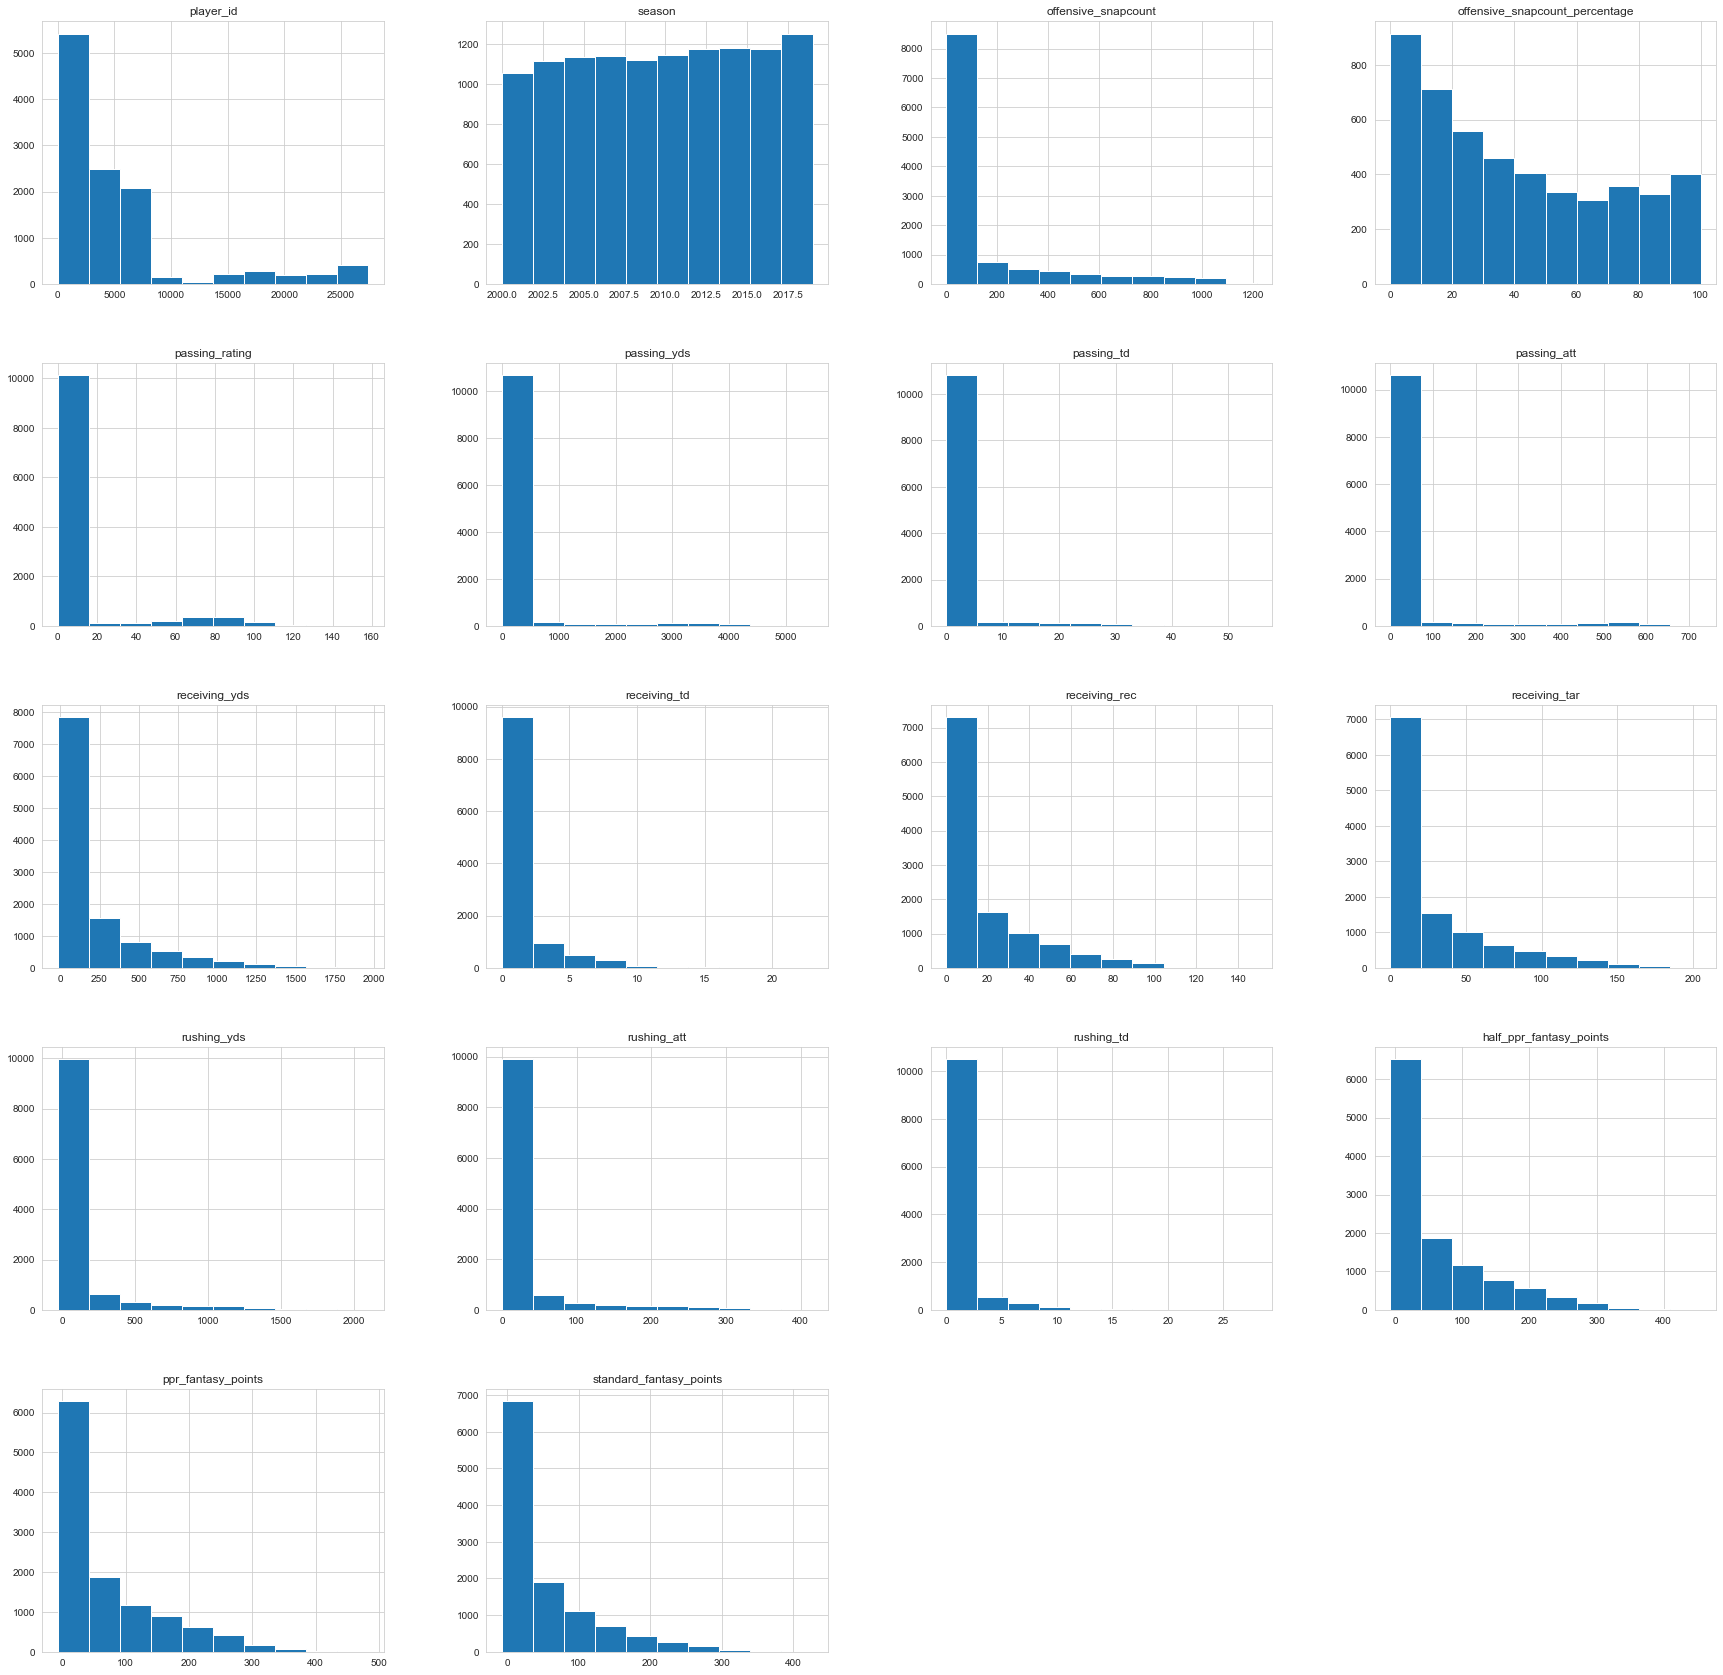

In [11]:
#looking at histogram of new dataframe
df.hist(figsize = (30,30))

In [12]:
df.head()

,player_id,tm,player,pos,season,offensive_snapcount,offensive_snapcount_percentage,passing_rating,passing_yds,passing_td,passing_att,receiving_yds,receiving_td,receiving_rec,receiving_tar,rushing_yds,rushing_att,rushing_td,half_ppr_fantasy_points,ppr_fantasy_points,standard_fantasy_points
0,2,CHI,Justin Gage,WR,2003,0.0,NaN,0.0,0.0,0.0,0.0,338.0,2.0,17.0,35.0,0.0,0.0,0.0,54.3,62.8,45.8
1,2,CHI,Justin Gage,WR,2004,0.0,NaN,0.0,0.0,0.0,0.0,156.0,0.0,12.0,28.0,0.0,0.0,0.0,21.6,27.6,15.6
2,2,CHI,Justin Gage,WR,2005,0.0,NaN,0.0,0.0,0.0,0.0,346.0,2.0,31.0,55.0,0.0,0.0,0.0,62.1,77.6,46.6
3,2,CHI,Justin Gage,WR,2006,0.0,NaN,0.0,0.0,0.0,0.0,68.0,0.0,4.0,8.0,0.0,0.0,0.0,8.8,10.8,6.8
4,2,OTI,Justin Gage,WR,2007,0.0,NaN,0.0,0.0,0.0,0.0,750.0,2.0,55.0,85.0,0.0,0.0,0.0,114.5,142.0,87.0


<AxesSubplot:xlabel='offensive_snapcount', ylabel='season'>

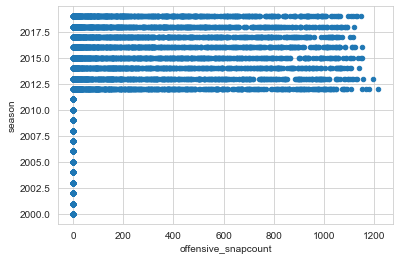

In [13]:
#Plotting snap counts to find out when snap count data started being tracked
df.plot( kind = 'scatter', x = 'offensive_snapcount', y = 'season')


We see snap count data starts in 2012. I would like to use snapcount as a feature for the model, so this will be the minimum starting year for our model's data

In [14]:
#Removing all data before 2012 in our df
df = df[df['season'] > 2011]
df.head(20)

,player_id,tm,player,pos,season,offensive_snapcount,offensive_snapcount_percentage,passing_rating,passing_yds,passing_td,passing_att,receiving_yds,receiving_td,receiving_rec,receiving_tar,rushing_yds,rushing_att,rushing_td,half_ppr_fantasy_points,ppr_fantasy_points,standard_fantasy_points
18,8,HTX,Nate Washington,WR,2015,793.0,76.428571,0.000,0.0,0.0,0.0,658.0,4.0,47.0,94.0,0.0,0.0,0.0,113.3,136.8,89.8
22,8,OTI,Nate Washington,WR,2012,789.0,78.125000,0.000,0.0,0.0,0.0,746.0,4.0,46.0,89.0,0.0,0.0,0.0,121.6,144.6,98.6
23,8,OTI,Nate Washington,WR,2013,887.0,82.500000,0.000,0.0,0.0,0.0,919.0,3.0,58.0,105.0,0.0,0.0,0.0,138.9,167.9,109.9
24,8,OTI,Nate Washington,WR,2014,767.0,78.437500,0.000,0.0,0.0,0.0,647.0,2.0,40.0,72.0,0.0,0.0,0.0,96.7,116.7,76.7
29,9,CRD,Chris Johnson,RB,2015,366.0,47.636364,0.000,0.0,0.0,0.0,58.0,0.0,6.0,13.0,814.0,196.0,3.0,108.2,111.2,105.2
30,9,CRD,Chris Johnson,RB,2016,42.0,15.000000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,95.0,25.0,1.0,15.5,15.5,15.5
31,9,CRD,Chris Johnson,RB,2017,107.0,36.250000,0.000,0.0,0.0,0.0,43.0,0.0,5.0,6.0,114.0,45.0,0.0,18.2,20.7,15.7
32,9,NYJ,Chris Johnson,RB,2014,399.0,36.812500,0.000,0.0,0.0,0.0,151.0,1.0,24.0,34.0,663.0,155.0,1.0,105.4,117.4,93.4
37,9,OTI,Chris Johnson,RB,2012,813.0,81.875000,0.000,0.0,0.0,0.0,232.0,0.0,36.0,49.0,1243.0,276.0,6.0,201.5,219.5,183.5
38,9,OTI,Chris Johnson,RB,2013,798.0,74.625000,0.000,0.0,0.0,0.0,345.0,4.0,42.0,52.0,1077.0,279.0,6.0,223.2,244.2,202.2


In [15]:
#using .shape to see we have 4786 columns and 21 rows of features
df.shape

(4786, 21)

In [16]:
df.columns

Index(['player_id', 'tm', 'player', 'pos', 'season', 'offensive_snapcount',
       'offensive_snapcount_percentage', 'passing_rating', 'passing_yds',
       'passing_td', 'passing_att', 'receiving_yds', 'receiving_td',
       'receiving_rec', 'receiving_tar', 'rushing_yds', 'rushing_att',
       'rushing_td', 'half_ppr_fantasy_points', 'ppr_fantasy_points',
       'standard_fantasy_points'],
      dtype='object')

In [17]:
pd.set_option('chained_assignment', None)

#lag features to get past years statistics and create a new column for them in the dataframe
#The most common league setting and the setting I personally use is Half PPR, so this is what I will be using
lag_features = [
    'offensive_snapcount',
    'offensive_snapcount_percentage',
    'passing_rating',
    'passing_yds',
    'passing_td',
    'passing_att',
    'receiving_yds',
    'receiving_td',
    'receiving_rec',
    'receiving_tar',
    'rushing_yds',
    'rushing_att',
    'rushing_td',
    'half_ppr_fantasy_points'
]

#for loop creating the new lag columns
#lag_passing_yds_1 would be passing yards 1 year ago, lag_receiving_rec_3 would be receptions 3 years ago
#using python f-strings
for lag in range(1,6):
    shifted = df.groupby('player_id').shift(lag)
    for column in lag_features:
        df[f'lag_{column}_{lag}'] = shifted[column]
        
#filling na columns with -1        
df = df.fillna(-1)

In [18]:
df.head(20)

,player_id,tm,player,pos,season,offensive_snapcount,offensive_snapcount_percentage,passing_rating,passing_yds,passing_td,passing_att,receiving_yds,receiving_td,receiving_rec,receiving_tar,rushing_yds,rushing_att,rushing_td,half_ppr_fantasy_points,ppr_fantasy_points,standard_fantasy_points,lag_offensive_snapcount_1,lag_offensive_snapcount_percentage_1,lag_passing_rating_1,lag_passing_yds_1,lag_passing_td_1,lag_passing_att_1,lag_receiving_yds_1,lag_receiving_td_1,lag_receiving_rec_1,lag_receiving_tar_1,lag_rushing_yds_1,lag_rushing_att_1,lag_rushing_td_1,lag_half_ppr_fantasy_points_1,lag_offensive_snapcount_2,lag_offensive_snapcount_percentage_2,lag_passing_rating_2,lag_passing_yds_2,lag_passing_td_2,lag_passing_att_2,lag_receiving_yds_2,lag_receiving_td_2,lag_receiving_rec_2,lag_receiving_tar_2,lag_rushing_yds_2,lag_rushing_att_2,lag_rushing_td_2,lag_half_ppr_fantasy_points_2,lag_offensive_snapcount_3,lag_offensive_snapcount_percentage_3,lag_passing_rating_3,lag_passing_yds_3,lag_passing_td_3,lag_passing_att_3,lag_receiving_yds_3,lag_receiving_td_3,lag_receiving_rec_3,lag_receiving_tar_3,lag_rushing_yds_3,lag_rushing_att_3,lag_rushing_td_3,lag_half_ppr_fantasy_points_3,lag_offensive_snapcount_4,lag_offensive_snapcount_percentage_4,lag_passing_rating_4,lag_passing_yds_4,lag_passing_td_4,lag_passing_att_4,lag_receiving_yds_4,lag_receiving_td_4,lag_receiving_rec_4,lag_receiving_tar_4,lag_rushing_yds_4,lag_rushing_att_4,lag_rushing_td_4,lag_half_ppr_fantasy_points_4,lag_offensive_snapcount_5,lag_offensive_snapcount_percentage_5,lag_passing_rating_5,lag_passing_yds_5,lag_passing_td_5,lag_passing_att_5,lag_receiving_yds_5,lag_receiving_td_5,lag_receiving_rec_5,lag_receiving_tar_5,lag_rushing_yds_5,lag_rushing_att_5,lag_rushing_td_5,lag_half_ppr_fantasy_points_5
18,8,HTX,Nate Washington,WR,2015,793.0,76.428571,0.000,0.0,0.0,0.0,658.0,4.0,47.0,94.0,0.0,0.0,0.0,113.3,136.8,89.8,-1.0,-1.000000,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
22,8,OTI,Nate Washington,WR,2012,789.0,78.125000,0.000,0.0,0.0,0.0,746.0,4.0,46.0,89.0,0.0,0.0,0.0,121.6,144.6,98.6,793.0,76.428571,0.000,0.0,0.0,0.0,658.0,4.0,47.0,94.0,0.0,0.0,0.0,113.3,-1.0,-1.000000,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
23,8,OTI,Nate Washington,WR,2013,887.0,82.500000,0.000,0.0,0.0,0.0,919.0,3.0,58.0,105.0,0.0,0.0,0.0,138.9,167.9,109.9,789.0,78.125000,0.000,0.0,0.0,0.0,746.0,4.0,46.0,89.0,0.0,0.0,0.0,121.6,793.0,76.428571,0.000,0.0,0.0,0.0,658.0,4.0,47.0,94.0,0.0,0.0,0.0,113.3,-1.0,-1.000000,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
24,8,OTI,Nate Washington,WR,2014,767.0,78.437500,0.000,0.0,0.0,0.0,647.0,2.0,40.0,72.0,0.0,0.0,0.0,96.7,116.7,76.7,887.0,82.500000,0.000,0.0,0.0,0.0,919.0,3.0,58.0,105.0,0.0,0.0,0.0,138.9,789.0,78.125000,0.000,0.0,0.0,0.0,746.0,4.0,46.0,89.0,0.0,0.0,0.0,121.6,793.0,76.428571,0.000,0.0,0.0,0.0,658.0,4.0,47.0,94.0,0.0,0.0,0.0,113.3,-1.0,-1.000000,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
29,9,CRD,Chris Johnson,RB,2015,366.0,47.636364,0.000,0.0,0.0,0.0,58.0,0.0,6.0,13.0,814.0,196.0,3.0,108.2,111.2,105.2,-1.0,-1.000000,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000,-1.0,-1.0,-1.0,-1.0,-1.

In [19]:
#I am going to use a correlation matrix with the lagged features 
#to see which features have the highest correlation to fantasy points

#I want to see all the rows here
pd.set_option("display.max_rows", None)

#The most common league setting and the setting I personally use is Half PPR, so this is what I will be using for all models
df.corr()[['half_ppr_fantasy_points']]

,half_ppr_fantasy_points
player_id,-0.160409
season,-0.012040
offensive_snapcount,0.875993
offensive_snapcount_percentage,0.770135
passing_rating,0.383181
passing_yds,0.546238
passing_td,0.555775
passing_att,0.536422
receiving_yds,0.599266
receiving_td,0.540091


As Expected, the farther back you go with the data, the lower correlation it has to Fantasy points. This correlation matrix is for every position, I want to look at every position seperately so I can see what features matter the most for individual positions. I suspect I will want 4 different models to predict the 4 major offensive positions: QB, RB, WR, TE

In [20]:
df.loc[df['pos'] == 'QB'].corr()[['half_ppr_fantasy_points']]

,half_ppr_fantasy_points
player_id,-0.106715
season,0.014762
offensive_snapcount,0.965808
offensive_snapcount_percentage,0.747568
passing_rating,0.639670
passing_yds,0.971074
passing_td,0.969342
passing_att,0.953508
receiving_yds,-0.007139
receiving_td,0.019900


In [21]:
df.loc[df['pos'] == 'WR'].corr()[['half_ppr_fantasy_points']]

,half_ppr_fantasy_points
player_id,-0.213111
season,-0.050171
offensive_snapcount,0.915676
offensive_snapcount_percentage,0.820417
passing_rating,0.168177
passing_yds,0.133992
passing_td,0.143808
passing_att,0.179172
receiving_yds,0.988214
receiving_td,0.910630


In [22]:
df.loc[df['pos'] == 'RB'].corr()[['half_ppr_fantasy_points']]

,half_ppr_fantasy_points
player_id,-0.096740
season,0.026460
offensive_snapcount,0.914968
offensive_snapcount_percentage,0.822234
passing_rating,0.142034
passing_yds,0.126019
passing_td,0.132094
passing_att,0.148721
receiving_yds,0.830861
receiving_td,0.620549


In [23]:
df.loc[df['pos'] == 'TE'].corr()[['half_ppr_fantasy_points']]

,half_ppr_fantasy_points
player_id,-0.168944
season,-0.032770
offensive_snapcount,0.858660
offensive_snapcount_percentage,0.798836
passing_rating,0.038587
passing_yds,0.032278
passing_td,NaN
passing_att,0.088537
receiving_yds,0.984647
receiving_td,0.894625


#note that I am primarily looking at "lag" features because I am using past statistics to predict future statistics

As I expected, WR and TE positions (the positions that catch the ball the overwhelming majority of the time) have the highest correlation with "receiving" metrics, while the rushing metrics have a very low correlation. That is because most of the players at these position will never rush or have rushing statistics.

This logic also applies to QBs, in that the "passing" metrics have the strongest correlation to fantasy points, and the "receiving" metrics have the lowest. It is worth mentioning that the "rushing" metrics have a much higher correlation for QBs as well compared to WRs and TEs. It is not as important as "passing" metrics, but it is an import feature that should be noted when thinking about what is valuable for QBs.

Running backs both are apart of the rushing game and passing game, so this position is the most "balanced" in terms of correlations between features. While the "rushing" metrics show a slightly higher correlation to fantasy points for RBs, "receiving" metrics are not very far behind

Now I will make seperate dataframes for each position. I also want to remove 2019 data from this df to use it for testing in my model. Because rookies and players with very low past data points are difficult to predict, I am also going to use a minimum snap count threshold of 50 snaps to better predict the players.


<AxesSubplot:xlabel='lag_offensive_snapcount_1', ylabel='half_ppr_fantasy_points'>

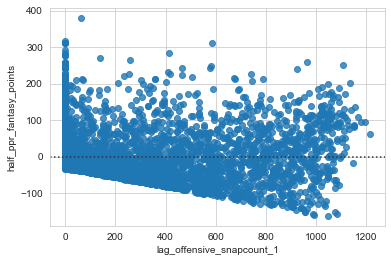

In [24]:
#plotting snapcount vs fantasy points, we see here that the closer to 0 we are, the more one-sided it is
sns.residplot( x = df['lag_offensive_snapcount_1'], y = df['half_ppr_fantasy_points'] )

#this is why I will be using a minimum snapcount threshold of 50 snaps from lag 1

In [25]:
#Filtering df to only include players with greater than 50 snaps from the previous season
df = df.loc[df['lag_offensive_snapcount_1'] > 50]
df.head(20)

,player_id,tm,player,pos,season,offensive_snapcount,offensive_snapcount_percentage,passing_rating,passing_yds,passing_td,passing_att,receiving_yds,receiving_td,receiving_rec,receiving_tar,rushing_yds,rushing_att,rushing_td,half_ppr_fantasy_points,ppr_fantasy_points,standard_fantasy_points,lag_offensive_snapcount_1,lag_offensive_snapcount_percentage_1,lag_passing_rating_1,lag_passing_yds_1,lag_passing_td_1,lag_passing_att_1,lag_receiving_yds_1,lag_receiving_td_1,lag_receiving_rec_1,lag_receiving_tar_1,lag_rushing_yds_1,lag_rushing_att_1,lag_rushing_td_1,lag_half_ppr_fantasy_points_1,lag_offensive_snapcount_2,lag_offensive_snapcount_percentage_2,lag_passing_rating_2,lag_passing_yds_2,lag_passing_td_2,lag_passing_att_2,lag_receiving_yds_2,lag_receiving_td_2,lag_receiving_rec_2,lag_receiving_tar_2,lag_rushing_yds_2,lag_rushing_att_2,lag_rushing_td_2,lag_half_ppr_fantasy_points_2,lag_offensive_snapcount_3,lag_offensive_snapcount_percentage_3,lag_passing_rating_3,lag_passing_yds_3,lag_passing_td_3,lag_passing_att_3,lag_receiving_yds_3,lag_receiving_td_3,lag_receiving_rec_3,lag_receiving_tar_3,lag_rushing_yds_3,lag_rushing_att_3,lag_rushing_td_3,lag_half_ppr_fantasy_points_3,lag_offensive_snapcount_4,lag_offensive_snapcount_percentage_4,lag_passing_rating_4,lag_passing_yds_4,lag_passing_td_4,lag_passing_att_4,lag_receiving_yds_4,lag_receiving_td_4,lag_receiving_rec_4,lag_receiving_tar_4,lag_rushing_yds_4,lag_rushing_att_4,lag_rushing_td_4,lag_half_ppr_fantasy_points_4,lag_offensive_snapcount_5,lag_offensive_snapcount_percentage_5,lag_passing_rating_5,lag_passing_yds_5,lag_passing_td_5,lag_passing_att_5,lag_receiving_yds_5,lag_receiving_td_5,lag_receiving_rec_5,lag_receiving_tar_5,lag_rushing_yds_5,lag_rushing_att_5,lag_rushing_td_5,lag_half_ppr_fantasy_points_5
22,8,OTI,Nate Washington,WR,2012,789.0,78.125000,0.000000,0.0,0.0,0.0,746.0,4.0,46.0,89.0,0.0,0.0,0.0,121.60,144.60,98.60,793.0,76.428571,0.000000,0.0,0.0,0.0,658.0,4.0,47.0,94.0,0.0,0.0,0.0,113.30,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.00,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
23,8,OTI,Nate Washington,WR,2013,887.0,82.500000,0.000000,0.0,0.0,0.0,919.0,3.0,58.0,105.0,0.0,0.0,0.0,138.90,167.90,109.90,789.0,78.125000,0.000000,0.0,0.0,0.0,746.0,4.0,46.0,89.0,0.0,0.0,0.0,121.60,793.0,76.428571,0.000000,0.0,0.0,0.0,658.0,4.0,47.0,94.0,0.0,0.0,0.0,113.30,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
24,8,OTI,Nate Washington,WR,2014,767.0,78.437500,0.000000,0.0,0.0,0.0,647.0,2.0,40.0,72.0,0.0,0.0,0.0,96.70,116.70,76.70,887.0,82.500000,0.000000,0.0,0.0,0.0,919.0,3.0,58.0,105.0,0.0,0.0,0.0,138.90,789.0,78.125000,0.000000,0.0,0.0,0.0,746.0,4.0,46.0,89.0,0.0,0.0,0.0,121.60,793.0,76.428571,0.000000,0.0,0.0,0.0,658.0,4.0,47.0,94.0,0.0,0.0,0.0,113.3,-1.0,-1.000000,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
30,9,CRD,Chris Johnson,RB,2016,42.0,15.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,95.0,25.0,1.0,15.50,15.50,15.50,366.0,47.636364,0.000000,0.0,0.0,0.0,58.0,0.0,6.0,13.0,814.0,196.0,3.0,108.20,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.00,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
32,9,NYJ,Chris Johnson,RB,2014,399.0,36.812500,0.000000,0.0,0.0,0.0,151.0,1.0,24.0,34.0,663.0,155.0,1.0,105.40,117.40,93.40,107.0,36.250000,0.000000,0.0,0.0,0.0,43.0,0.0,5.0,6.0,114

In [26]:
#Creating seperate dataframes for each position, and also filtering out 2019 data to use for testing
qb_df = df.loc[(df['pos'] == 'QB') & (df['season'] < 2019)]
wr_df = df.loc[(df['pos'] == 'WR') & (df['season'] < 2019)]
rb_df = df.loc[(df['pos'] == 'RB') & (df['season'] < 2019)]
te_df = df.loc[(df['pos'] == 'TE') & (df['season'] < 2019)]


In [27]:
wr_df.head()

,player_id,tm,player,pos,season,offensive_snapcount,offensive_snapcount_percentage,passing_rating,passing_yds,passing_td,passing_att,receiving_yds,receiving_td,receiving_rec,receiving_tar,rushing_yds,rushing_att,rushing_td,half_ppr_fantasy_points,ppr_fantasy_points,standard_fantasy_points,lag_offensive_snapcount_1,lag_offensive_snapcount_percentage_1,lag_passing_rating_1,lag_passing_yds_1,lag_passing_td_1,lag_passing_att_1,lag_receiving_yds_1,lag_receiving_td_1,lag_receiving_rec_1,lag_receiving_tar_1,lag_rushing_yds_1,lag_rushing_att_1,lag_rushing_td_1,lag_half_ppr_fantasy_points_1,lag_offensive_snapcount_2,lag_offensive_snapcount_percentage_2,lag_passing_rating_2,lag_passing_yds_2,lag_passing_td_2,lag_passing_att_2,lag_receiving_yds_2,lag_receiving_td_2,lag_receiving_rec_2,lag_receiving_tar_2,lag_rushing_yds_2,lag_rushing_att_2,lag_rushing_td_2,lag_half_ppr_fantasy_points_2,lag_offensive_snapcount_3,lag_offensive_snapcount_percentage_3,lag_passing_rating_3,lag_passing_yds_3,lag_passing_td_3,lag_passing_att_3,lag_receiving_yds_3,lag_receiving_td_3,lag_receiving_rec_3,lag_receiving_tar_3,lag_rushing_yds_3,lag_rushing_att_3,lag_rushing_td_3,lag_half_ppr_fantasy_points_3,lag_offensive_snapcount_4,lag_offensive_snapcount_percentage_4,lag_passing_rating_4,lag_passing_yds_4,lag_passing_td_4,lag_passing_att_4,lag_receiving_yds_4,lag_receiving_td_4,lag_receiving_rec_4,lag_receiving_tar_4,lag_rushing_yds_4,lag_rushing_att_4,lag_rushing_td_4,lag_half_ppr_fantasy_points_4,lag_offensive_snapcount_5,lag_offensive_snapcount_percentage_5,lag_passing_rating_5,lag_passing_yds_5,lag_passing_td_5,lag_passing_att_5,lag_receiving_yds_5,lag_receiving_td_5,lag_receiving_rec_5,lag_receiving_tar_5,lag_rushing_yds_5,lag_rushing_att_5,lag_rushing_td_5,lag_half_ppr_fantasy_points_5
22,8,OTI,Nate Washington,WR,2012,789.0,78.1250,0.000,0.0,0.0,0.0,746.0,4.0,46.0,89.0,0.0,0.0,0.0,121.6,144.6,98.6,793.0,76.428571,0.000,0.0,0.0,0.0,658.0,4.0,47.0,94.0,0.0,0.0,0.0,113.3,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
23,8,OTI,Nate Washington,WR,2013,887.0,82.5000,0.000,0.0,0.0,0.0,919.0,3.0,58.0,105.0,0.0,0.0,0.0,138.9,167.9,109.9,789.0,78.125000,0.000,0.0,0.0,0.0,746.0,4.0,46.0,89.0,0.0,0.0,0.0,121.6,793.0,76.428571,0.0,0.0,0.0,0.0,658.0,4.0,47.0,94.0,0.0,0.0,0.0,113.3,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
24,8,OTI,Nate Washington,WR,2014,767.0,78.4375,0.000,0.0,0.0,0.0,647.0,2.0,40.0,72.0,0.0,0.0,0.0,96.7,116.7,76.7,887.0,82.500000,0.000,0.0,0.0,0.0,919.0,3.0,58.0,105.0,0.0,0.0,0.0,138.9,789.0,78.125000,0.0,0.0,0.0,0.0,746.0,4.0,46.0,89.0,0.0,0.0,0.0,121.6,793.0,76.428571,0.0,0.0,0.0,0.0,658.0,4.0,47.0,94.0,0.0,0.0,0.0,113.3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
40,10,MIA,Mike Wallace,WR,2014,819.0,75.0625,2.475,0.0,0.0,1.0,862.0,10.0,67.0,115.0,16.0,4.0,0.0,181.3,214.8,147.8,951.0,92.875000,0.000,0.0,0.0,0.0,930.0,5.0,73.0,141.0,33.0,3.0,0.0,162.8,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
41,10,MIN,Mike Wallace,WR,2015,748.0,73.3750,0.000,0.0,0.0,0.0,473.0,2.0,39.0,72.0,6.0,1.0,0.0,79.4,98.9,59.9,819.0,75.062500,2.475,0.0,0.0,1.0,862.0,10.0,67.0,115.0,16.0,4.0,0.0,181.3,951.0,92.875000,0.0,0.0,0.0,0.0,930.0,5.0,73.0,141.0,33.0,3.0,0.0,162.8,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.

In [28]:
wr_df.shape

(865, 91)

I will start by modeling the Wide receivers. I am going to start by taking the top lag_1 correlation metrics in the WR dataframe to use in my model. I will use roughly the top 5-10 metrics in terms of correalation to half ppr fantasy points for each postition seperately

In [29]:
#confirming the correlation is roughly the same for the WR dataframe after having a minimum snapcount and removing 2019 data
#Will use about 5 features that have highest correlation in the models
#I am only going to use lag features because I want past season performance to predict future seasons

wr_df.corr()[['half_ppr_fantasy_points']]

,half_ppr_fantasy_points
player_id,-0.168442
season,-0.040385
offensive_snapcount,0.897144
offensive_snapcount_percentage,0.801505
passing_rating,0.159941
passing_yds,0.114023
passing_td,0.126117
passing_att,0.205662
receiving_yds,0.985385
receiving_td,0.899160


#WR modeling

#WR has 7 lag features with a correlation higher than .5, I will be using 6 of them: the 4 lag receiving metrics, as well as lag snapcounts and lag half ppr fantasy points (I do not need both snapcount and snapcount percentage, I will just use snapcount)


In [30]:
#WR has 7 lag features with a correlation higher than .5, I will be using 6 of them: the 4 lag receiving metrics, as well as lag snapcounts and half ppr fantasy points
#(I do not need both snapcount and snapcount percentage, which are both over .5, I will just use snapcount)


#useing .values to make numpy array
X = wr_df[[
    'lag_half_ppr_fantasy_points_1',
    'lag_receiving_yds_1',
    'lag_receiving_rec_1',
    'lag_receiving_tar_1',
    'lag_receiving_td_1',
    'lag_offensive_snapcount_1'
]].values


y = wr_df[['half_ppr_fantasy_points']].values


X.shape, y.shape

((865, 6), (865, 1))

In [31]:
#Training and test data for WR data, split up 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

In [32]:
#First thing I will do is get a baseline for the Wide Receivers based on a dummy regressor with a strategy of "mean"
#will use this to compare how well our other models did

#Dummy Regressor with strategy of "mean"
dummy_regr_wr = DummyRegressor(strategy="mean")

#fitting X and y data from WRs to the dummy regressor
dummy_regr_wr.fit(X_train, y_train)

#finding prediction
dummy_pred_wr = dummy_regr_wr.predict(X_test)

#finding the mean absolute error for test and predict
print('The mean absolute error is: ', mean_absolute_error(dummy_pred_wr, y_test))

The mean absolute error is:  60.32936533128403


By using the mean, we see that the mean absolute error is 60.33. This means for the whole season, we can expect this model will be off on average by about 60 points. Dividing this by 16 weeks (maximum games played for a player) we see we are off by 3.77 points per week. This is not terrible, but I believe we can do better.


In [33]:
#using a Linear Regression Model on the same data

#Linear Regression Model
lr = LinearRegression()


#fit the model with training data
lr.fit(X_train, y_train)

#predict values based on the testing data
y_pred = lr.predict(X_test)

#finding the mean absolute error for test and predict
print('The mean absolute error is: ', mean_absolute_error(y_pred, y_test))

#Value of 39.07 says that the prediction on average is 39.07 points off from the actual test data for yearly Fantasy points
#over a 16 game season this is on average off about 2.44 points per week

The mean absolute error is:  39.07041505178929


In [34]:
#now to use use my Linear Regression model to predict 2020 Fantasy points for WRs

wr_df_pred = df.loc[
    (df['pos'] == 'WR') & (df['offensive_snapcount'] > 50) & (df['season'] == 2019), 
    ['player',
    'half_ppr_fantasy_points',
    'receiving_yds',
    'receiving_rec',
    'receiving_tar',
    'receiving_td',
    'offensive_snapcount']
]

wr_df_pred['lr_predicted_2020'] = lr.predict(wr_df_pred[['half_ppr_fantasy_points',
    'receiving_yds',
    'receiving_rec',
    'receiving_tar',
    'receiving_td',
    'offensive_snapcount']].values)

#Merging 2020 predicted with 2020 actual Fantasy Points jsut to get an idea of how close the projections
#some players were affecting by injuries like our #1 projected player, Michael Thomas
wr_df_pred = pd.merge(wr_df_pred, df2020_half_ppr, on = 'player', how='left')

#sorting values by predicted fantasy points
#Looking at top 50 because players ranked lower than 50 are not as valuable
wr_df_pred.sort_values(by='lr_predicted_2020', ascending=False).head(50)

,player,half_ppr_fantasy_points,receiving_yds,receiving_rec,receiving_tar,receiving_td,offensive_snapcount,lr_predicted_2020,actual_2020
59,Michael Thomas,300.10,1725.0,149.0,185.0,9.0,942.0,243.196891,64.0
83,Chris Godwin,233.10,1333.0,86.0,120.0,9.0,937.0,184.795666,158.5
8,Julio Jones,224.60,1394.0,99.0,157.0,6.0,812.0,184.780540,120.5
78,Cooper Kupp,223.50,1161.0,94.0,134.0,10.0,886.0,173.930753,163.0
25,Keenan Allen,209.50,1199.0,104.0,149.0,6.0,931.0,172.467548,195.0
24,DeAndre Hopkins,216.54,1165.0,104.0,150.0,7.0,971.0,172.009638,230.5
48,Amari Cooper,207.00,1189.0,79.0,119.0,8.0,845.0,166.282898,191.0
31,Allen Robinson,205.90,1147.0,98.0,154.0,7.0,1003.0,165.377219,212.0
74,Kenny Golladay,215.50,1190.0,65.0,116.0,11.0,937.0,164.324373,56.0
51,DeVante Parker,210.20,1202.0,72.0,128.0,9.0,906.0,163.636757,134.5


In [35]:
#Lets see who were the actual 2020 Half PPR WR leaders, ranked by half ppr points
wr_df2020.head(50)

,player,Tm,Pos,Age,G,GS,Tgt,Rec,PassingYds,PassingTD,PassingAtt,RushingYds,RushingTD,RushingAtt,ReceivingYds,ReceivingTD,FantasyPoints,Int,Fumbles,FumblesLost,actual_2020
4,Davante Adams,GNB,WR,28,14,14,149,115,0,0,0,0,0,0,1374,18,243.0,0,1,1,300.5
5,Tyreek Hill,KAN,WR,26,15,15,135,87,0,0,0,123,2,13,1276,15,242.0,0,1,0,285.5
16,Stefon Diggs,BUF,WR,27,16,15,166,127,0,0,0,1,0,1,1535,8,202.0,0,0,0,265.5
19,Calvin Ridley,ATL,WR,26,15,15,143,90,0,0,0,1,0,5,1374,9,192.0,0,1,1,237.0
31,DeAndre Hopkins,ARI,WR,28,16,16,160,115,0,0,0,1,0,1,1407,6,173.0,0,3,2,230.5
23,Justin Jefferson,MIN,WR,21,16,14,125,88,0,0,0,2,0,1,1400,7,186.0,0,1,0,230.0
20,D.K. Metcalf,SEA,WR,23,16,16,129,83,0,0,0,0,0,0,1303,10,188.0,0,1,1,229.5
25,Adam Thielen,MIN,WR,30,15,15,108,74,0,0,0,15,0,3,925,14,180.0,0,0,0,217.0
33,Tyler Lockett,SEA,WR,28,16,16,132,100,0,0,0,0,0,0,1054,10,165.0,0,1,0,215.0
26,Mike Evans,TAM,WR,27,16,16,109,70,0,0,0,0,0,0,1006,13,179.0,0,0,0,214.0


While not perfect, this is a good starting point for a model. First thing I notice is the highest projected scorers are projected far less than their previous season statistics, and by the end of the top 100 WR list towards the bottom, they are projected more than their previous season. Perhaps a future model delving deeper into player projections, I would try to find a way to incorporate team data or player efficiency metrics along with previous season statistics into a model.

On the surface though, a lot of these players repeated as top players in 2020 compared to actual statistics.


Now I will do the same thing but use a Random Forest Model on the WRs, and compare the 2 models.

In [36]:
#GridSearch to find the optimal number of trees for the Random forest Model

#Define a pipeline comprising the steps:
#StandardScaler(),
#and then RandomForestRegressor() with a random state of 10
RF_pipe = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(random_state= 10)
)


n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'randomforestregressor__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None]
}
grid_params

{'randomforestregressor__n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'standardscaler': [StandardScaler(), None]}

In [37]:
#performing Grid search with scalar and grid params
rf_grid_cv = GridSearchCV(RF_pipe, param_grid= grid_params, cv= 5, n_jobs=-1)

#fitting Random forest grid
rf_grid_cv.fit(X_train, y_train)

#finding the best n_estimator
rf_grid_cv.best_params_

{'randomforestregressor__n_estimators': 88, 'standardscaler': None}

When running we see that the optimal n_estimators, or optimal number of trees for our Random Forest model is 88. We also see that scaling the features does not help

In [38]:
#Random Forrest Model for WR

#I am using the same X and y values for the this model as the Linear Regression WR model above


#Random forest instead of Linear Regresion, with n = 88 as a result from the grid search above
rf = RandomForestRegressor(n_estimators = 88)


#fit the model with training data
rf.fit(X_train, y_train)

#predict values based on the testing data
y_pred_rf = rf.predict(X_test)

In [39]:
#now to use use my RF model to predict 2020 Fantasy points for WRs

rf_wr_df_pred = df.loc[
    (df['pos'] == 'WR') & (df['offensive_snapcount'] > 50) & (df['season'] == 2019), 
    ['player',
    'half_ppr_fantasy_points',
    'receiving_yds',
    'receiving_rec',
    'receiving_tar',
    'receiving_td',
    'offensive_snapcount']
]

rf_wr_df_pred['rf_predicted_2020'] = rf.predict(rf_wr_df_pred[['half_ppr_fantasy_points',
    'receiving_yds',
    'receiving_rec',
    'receiving_tar',
    'receiving_td',
    'offensive_snapcount']].values)

#Merging 2020 predicted with 2020 actual Fantasy Points
rf_wr_df_pred = pd.merge(rf_wr_df_pred, df2020_half_ppr, on = 'player', how='left')

#sorting values by predicted fantasy points
rf_wr_df_pred.sort_values(by='rf_predicted_2020', ascending=False).head(50)

,player,half_ppr_fantasy_points,receiving_yds,receiving_rec,receiving_tar,receiving_td,offensive_snapcount,rf_predicted_2020,actual_2020
59,Michael Thomas,300.10,1725.0,149.0,185.0,9.0,942.0,247.928409,64.0
8,Julio Jones,224.60,1394.0,99.0,157.0,6.0,812.0,203.331136,120.5
25,Keenan Allen,209.50,1199.0,104.0,149.0,6.0,931.0,196.175909,195.0
34,Mike Evans,199.20,1157.0,67.0,118.0,8.0,792.0,187.622500,214.0
51,DeVante Parker,210.20,1202.0,72.0,128.0,9.0,906.0,186.917045,134.5
48,Amari Cooper,207.00,1189.0,79.0,119.0,8.0,845.0,183.546591,191.0
74,Kenny Golladay,215.50,1190.0,65.0,116.0,11.0,937.0,177.032955,56.0
78,Cooper Kupp,223.50,1161.0,94.0,134.0,10.0,886.0,175.698636,163.0
91,Courtland Sutton,186.42,1112.0,72.0,125.0,6.0,933.0,173.910227,8.5
97,Michael Gallup,179.70,1107.0,66.0,113.0,6.0,846.0,166.857955,143.5


In [40]:
#Comparing the top receivers from the RF model to the LR model, ranked by predicted fantasy points
rf_wr_df_pred = pd.merge(rf_wr_df_pred, wr_df_pred[['player','lr_predicted_2020']], on = 'player', how='left')

#Ranking players by ACTUAL 2020 fantasy points to see which model was closet in predictions
#ranking by 2020 data theoretically allows me to see which players were the least impacted by injuries,
#because injuries did not play a major role in their end of season 2020 statistics

rf_wr_df_pred.sort_values(by='actual_2020', ascending=False, ignore_index = 'True').head(50)

,player,half_ppr_fantasy_points,receiving_yds,receiving_rec,receiving_tar,receiving_td,offensive_snapcount,rf_predicted_2020,actual_2020,lr_predicted_2020
0,Davante Adams,171.20,997.0,83.0,127.0,5.0,678.0,128.670682,300.5,144.753283
1,Tyreek Hill,159.30,860.0,58.0,89.0,7.0,563.0,135.592727,285.5,129.566574
2,Stefon Diggs,180.60,1130.0,63.0,94.0,6.0,772.0,145.196591,265.5,152.241700
3,Calvin Ridley,165.50,866.0,63.0,93.0,7.0,712.0,129.030682,237.0,132.595741
4,DeAndre Hopkins,216.54,1165.0,104.0,150.0,7.0,971.0,158.225909,230.5,172.009638
5,Adam Thielen,99.40,418.0,30.0,48.0,6.0,436.0,106.178864,217.0,81.211290
6,Tyler Lockett,194.20,1057.0,82.0,110.0,8.0,994.0,133.939091,215.0,157.916836
7,Mike Evans,199.20,1157.0,67.0,118.0,8.0,792.0,187.622500,214.0,157.009812
8,Allen Robinson,205.90,1147.0,98.0,154.0,7.0,1003.0,114.064545,212.0,165.377219
9,Robert Woods,187.90,1134.0,90.0,139.0,2.0,988.0,155.830000,200.0,154.758512


In [41]:
#Comparing Mean absolute error for all models of the WR position to see which model performs best
print('The mean absolute error for the dummy regressor model is: ', mean_absolute_error(dummy_pred_wr, y_test))
print('The mean absolute error for the linear regression model is: ', mean_absolute_error(y_pred, y_test))
print('The mean absolute error for the random forest model is: ', mean_absolute_error(y_pred_rf, y_test))

The mean absolute error for the dummy regressor model is:  60.32936533128403
The mean absolute error for the linear regression model is:  39.07041505178929
The mean absolute error for the random forest model is:  41.69271544929059


Over a full season, the mean absolute error for WRs is slightly better for the linear forrest model by a total of about 3 points per season difference. Both out-performed the dummy regressor model by a good ammount.

Next I will be doing the same thing for the next 3 major offensive positions: RB, TE, and QB

In [42]:
#Correlation Matrix between metrics and RBs
#confirming the correlation is roughly the same for the RB dataframe after having a minimum snapcount and removing 2019 data
#I am only going to use lag features because I want past season performance to predict future seasons

rb_df.corr()[['half_ppr_fantasy_points']]

,half_ppr_fantasy_points
player_id,-0.077262
season,-0.016170
offensive_snapcount,0.908415
offensive_snapcount_percentage,0.815546
passing_rating,0.148574
passing_yds,0.159663
passing_td,0.180675
passing_att,0.177332
receiving_yds,0.814227
receiving_td,0.611673


interesting to see lag receving metrics have nearly the same correlation as rushing metrics for an RB, with some correlations even being higher

Because running backs have many features that have a similar correlation, I will be testing the model first with all lag correlations over .4 (using only snap count instead of snapcount percentage, consistent with the other models)

In [43]:
#RB modeling

#RB has 9 lag features with a correlation higher than .4, I will be using 8 of them in a similar manner to WR: 
#-the 3 lag receiving metrics (all lag receiving metrics except lag receiving td),
#-the 3 rushing metrics, 
#-as well as lag snapcounts and half ppr fantasy points
#(I do not need both snapcount and snapcount percentage, I will just use snapcount)


#useing .values to make numpy array
X2 = rb_df[[
    'lag_half_ppr_fantasy_points_1',
    'lag_receiving_yds_1',
    'lag_receiving_rec_1',
    'lag_receiving_tar_1',
    'lag_rushing_yds_1',
    'lag_rushing_att_1',
    'lag_rushing_td_1',
    'lag_offensive_snapcount_1'
]].values


y2 = rb_df[['half_ppr_fantasy_points']].values


X2.shape, y2.shape

((609, 8), (609, 1))

In [44]:
#Training and test data, split up 80% train, 20% test
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.2, random_state = 10)


In [45]:
#Like WR, I will use a dummy Regressor for the RB data based on a dummy regressor with a strategy of "mean"
#will use this to compare how well our other models did

#Dummy Regressor with strategy of "mean"
dummy_regr_rb = DummyRegressor(strategy="mean")

#fitting X and y data from RBs to the dummy regressor
dummy_regr_rb.fit(X2_train, y2_train)

#finding prediction
dummy_pred_rb = dummy_regr_rb.predict(X2_test)

#finding the mean absolute error for test and predict
print('The mean absolute error is: ', mean_absolute_error(dummy_pred_rb, y2_test))

The mean absolute error is:  59.54424075133808


In [46]:
#Linear Regression Model for RBs

lr2 = LinearRegression()


#fit the model with training data
lr2.fit(X2_train, y2_train)

#predict values based on the testing data
y2_pred = lr2.predict(X2_test)

#finding the mean absolute error for test and predict
print('The mean absolute error is: ', mean_absolute_error(y2_pred, y2_test))

#Value of 46.49 says that the prediction on average is 46.49 points off from the actual test data for yearly Fantasy points
#over a 16 game season this is on average off about 2.9 points per week

The mean absolute error is:  46.48509951101033


In [47]:
#now to use use my model to predict 2020 Fantasy points for RBs

rb_df_pred = df.loc[
    (df['pos'] == 'RB') & (df['offensive_snapcount'] > 50) & (df['season'] == 2019), 
    ['player',
    'half_ppr_fantasy_points',
    'receiving_yds',
    'receiving_rec',
    'receiving_tar',
    'rushing_yds',
    'rushing_att',
    'rushing_td',
    'offensive_snapcount']
]

rb_df_pred['lr_predicted_2020'] = lr2.predict(rb_df_pred[['half_ppr_fantasy_points',
    'receiving_yds',
    'receiving_rec',
    'receiving_tar',
    'rushing_yds',
    'rushing_att',
    'rushing_td',
    'offensive_snapcount']].values)

#Merging 2020 predicted with 2020 actual Fantasy Points
rb_df_pred = pd.merge(rb_df_pred, df2020_half_ppr, on = 'player', how='left')

#sorting values by predicted fantasy points
rb_df_pred.sort_values(by='lr_predicted_2020', ascending=False).head(50)

,player,half_ppr_fantasy_points,receiving_yds,receiving_rec,receiving_tar,rushing_yds,rushing_att,rushing_td,offensive_snapcount,lr_predicted_2020,actual_2020
46,Christian McCaffrey,413.20,1005.0,116.0,142.0,1387.0,287.0,15.0,1039.0,271.231845,NaN
50,Dalvin Cook,265.90,519.0,53.0,63.0,1135.0,250.0,13.0,604.0,199.667034,316.0
42,Leonard Fournette,221.40,522.0,76.0,100.0,1152.0,265.0,3.0,904.0,198.555598,NaN
56,Nick Chubb,237.20,278.0,36.0,49.0,1494.0,298.0,8.0,715.0,194.794363,200.0
51,Austin Ekeler,263.00,993.0,92.0,108.0,557.0,132.0,3.0,599.0,190.112897,138.0
48,Alvin Kamara,208.02,533.0,81.0,97.0,797.0,171.0,5.0,626.0,184.399689,336.5
33,Ezekiel Elliott,284.70,420.0,54.0,71.0,1357.0,301.0,12.0,937.0,177.736195,198.0
32,Derrick Henry,285.60,206.0,18.0,24.0,1540.0,303.0,16.0,589.0,177.047093,NaN
68,Saquon Barkley,218.10,438.0,52.0,73.0,1003.0,217.0,6.0,728.0,158.229876,12.0
45,Chris Carson,214.10,266.0,37.0,47.0,1230.0,278.0,7.0,723.0,158.067689,169.5


In [48]:
#Lets look at how the prediction stack up against the actual 2020 RB leaders
rb_df2020.head(50)

,player,Tm,Pos,Age,G,GS,Tgt,Rec,PassingYds,PassingTD,PassingAtt,RushingYds,RushingTD,RushingAtt,ReceivingYds,ReceivingTD,FantasyPoints,Int,Fumbles,FumblesLost,actual_2020
1,Alvin Kamara,NOR,RB,25,15,10,107,83,0,0,0,932,16,187,756,5,295.0,0,1,0,336.5
0,Derrick Henry,TEN,RB,26,16,16,31,19,0,0,0,2027,17,378,114,0,314.0,0,3,2,323.5
2,Dalvin Cook,MIN,RB,25,14,14,54,44,0,0,0,1557,16,312,361,1,294.0,0,5,3,316.0
14,David Montgomery,CHI,RB,23,15,14,68,54,0,0,0,1070,8,247,438,2,211.0,0,1,1,238.0
12,Aaron Jones,GNB,RB,26,14,14,63,47,0,0,0,1104,9,201,355,2,212.0,0,2,0,235.5
11,Jonathan Taylor,IND,RB,21,15,13,39,36,0,0,0,1169,11,232,299,1,217.0,0,1,1,235.0
17,James Robinson,JAX,RB,22,14,14,60,49,0,0,0,1070,7,240,344,3,201.0,0,3,1,225.5
18,Josh Jacobs,LVR,RB,22,15,15,45,33,0,0,0,1065,12,273,238,0,198.0,0,2,2,214.5
30,Kareem Hunt,CLE,RB,25,16,5,51,38,0,0,0,841,6,198,304,5,181.0,0,2,0,200.0
21,Nick Chubb,CLE,RB,25,12,12,18,16,0,0,0,1067,12,190,150,0,192.0,0,1,1,200.0


Model looks good again. 5 of the top 10 predicted fantasy players in 2020 actually finished in the top 12, and at least 2 were excluded primarily because of injury (even though per game they were top 10 players and would have likely finished in the top 10 as predicted)

Now I will use a Random Forrest Model on the same data and see which model performs better

In [49]:
#GridSearch to find the optimal number of trees for the Random forest Model

#Define a pipeline comprising the steps:
#StandardScaler(),
#and then RandomForestRegressor() with a random state of 10
RF_pipe2 = make_pipeline(
    RandomForestRegressor(random_state= 10)
)


n_est2 = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params2 = {
        'randomforestregressor__n_estimators': n_est2
}

#performing Grid search with scalar and grid params
rf_grid_cv2 = GridSearchCV(RF_pipe2, param_grid= grid_params2, cv= 5, n_jobs=-1)

#fitting Random forest grid
rf_grid_cv2.fit(X2_train, y2_train)

#finding the best n_estimator
rf_grid_cv2.best_params_

{'randomforestregressor__n_estimators': 1000}

We see the optimal number of trees for this Random forrest model is 1000. I will use this for the n_estimators in the next Random Forrest Regression model.

In [50]:
#Linear Regression Model for RBs

rf2 = RandomForestRegressor(n_estimators=1000)


#fit the model with training data
rf2.fit(X2_train, y2_train)

#predict values based on the testing data
y2_pred_rf = rf2.predict(X2_test)

#finding the mean absolute error for test and predict
print('The mean absolute error is: ', mean_absolute_error(y2_pred_rf, y2_test))


The mean absolute error is:  50.78459540983612


In [51]:
#now to use use my model to predict 2020 Fantasy points for RBs

rf_rb_df_pred = df.loc[
    (df['pos'] == 'RB') & (df['offensive_snapcount'] > 50) & (df['season'] == 2019), 
    ['player',
    'half_ppr_fantasy_points',
    'receiving_yds',
    'receiving_rec',
    'receiving_tar',
    'rushing_yds',
    'rushing_att',
    'rushing_td',
    'offensive_snapcount']
]

rf_rb_df_pred['rf_predicted_2020'] = rf2.predict(rf_rb_df_pred[['half_ppr_fantasy_points',
    'receiving_yds',
    'receiving_rec',
    'receiving_tar',
    'rushing_yds',
    'rushing_att',
    'rushing_td',
    'offensive_snapcount']].values)

#Merging 2020 predicted with 2020 actual Fantasy Points
rf_rb_df_pred = pd.merge(rf_rb_df_pred, df2020_half_ppr, on = 'player', how='left')

#sorting values by predicted fantasy points
rf_rb_df_pred.sort_values(by='rf_predicted_2020', ascending=False).head(50)

,player,half_ppr_fantasy_points,receiving_yds,receiving_rec,receiving_tar,rushing_yds,rushing_att,rushing_td,offensive_snapcount,rf_predicted_2020,actual_2020
46,Christian McCaffrey,413.20,1005.0,116.0,142.0,1387.0,287.0,15.0,1039.0,216.20560,NaN
42,Leonard Fournette,221.40,522.0,76.0,100.0,1152.0,265.0,3.0,904.0,215.79670,NaN
45,Chris Carson,214.10,266.0,37.0,47.0,1230.0,278.0,7.0,723.0,212.67920,169.5
56,Nick Chubb,237.20,278.0,36.0,49.0,1494.0,298.0,8.0,715.0,200.89080,200.0
39,Joe Mixon,207.90,287.0,35.0,45.0,1137.0,278.0,5.0,653.0,187.23150,89.5
32,Derrick Henry,285.60,206.0,18.0,24.0,1540.0,303.0,16.0,589.0,186.58880,NaN
25,Todd Gurley,203.90,207.0,31.0,49.0,857.0,223.0,12.0,789.0,186.02660,150.5
48,Alvin Kamara,208.02,533.0,81.0,97.0,797.0,171.0,5.0,626.0,185.57994,336.5
68,Saquon Barkley,218.10,438.0,52.0,73.0,1003.0,217.0,6.0,728.0,185.06950,12.0
2,Mark Ingram,229.50,247.0,26.0,29.0,1018.0,202.0,10.0,504.0,174.49850,50.0


In [52]:
#Comparing the top RBs from the RF model to the LR model, ranked by predicted fantasy points
rf_rb_df_pred = pd.merge(rf_rb_df_pred, rb_df_pred[['player','lr_predicted_2020']], on = 'player', how='left')

#sorting by Random Forrest Prediction
rf_rb_df_pred.sort_values(by='rf_predicted_2020', ascending=False, ignore_index = 'True').head(50)

,player,half_ppr_fantasy_points,receiving_yds,receiving_rec,receiving_tar,rushing_yds,rushing_att,rushing_td,offensive_snapcount,rf_predicted_2020,actual_2020,lr_predicted_2020
0,Christian McCaffrey,413.20,1005.0,116.0,142.0,1387.0,287.0,15.0,1039.0,216.20560,NaN,271.231845
1,Leonard Fournette,221.40,522.0,76.0,100.0,1152.0,265.0,3.0,904.0,215.79670,NaN,198.555598
2,Chris Carson,214.10,266.0,37.0,47.0,1230.0,278.0,7.0,723.0,212.67920,169.5,158.067689
3,Nick Chubb,237.20,278.0,36.0,49.0,1494.0,298.0,8.0,715.0,200.89080,200.0,194.794363
4,Joe Mixon,207.90,287.0,35.0,45.0,1137.0,278.0,5.0,653.0,187.23150,89.5,146.944311
5,Derrick Henry,285.60,206.0,18.0,24.0,1540.0,303.0,16.0,589.0,186.58880,NaN,177.047093
6,Todd Gurley,203.90,207.0,31.0,49.0,857.0,223.0,12.0,789.0,186.02660,150.5,93.280007
7,Alvin Kamara,208.02,533.0,81.0,97.0,797.0,171.0,5.0,626.0,185.57994,336.5,184.399689
8,Saquon Barkley,218.10,438.0,52.0,73.0,1003.0,217.0,6.0,728.0,185.06950,12.0,158.229876
9,Mark Ingram,229.50,247.0,26.0,29.0,1018.0,202.0,10.0,504.0,174.49850,50.0,124.412498


In [53]:
#Comparing Mean absolute error for all models of the RB position to see which model performs best
print('The mean absolute error for the dummy regressor model is: ', mean_absolute_error(dummy_pred_rb, y2_test))
print('The mean absolute error for the linear regression model is: ', mean_absolute_error(y2_pred, y2_test))
print('The mean absolute error for the random forest model is: ', mean_absolute_error(y2_pred_rf, y2_test))

The mean absolute error for the dummy regressor model is:  59.54424075133808
The mean absolute error for the linear regression model is:  46.48509951101033
The mean absolute error for the random forest model is:  50.78459540983612


Again, The Linear Regression Model seems to perform a bit better by about 3.5 points on the season compared to the Random Forrest model, while both of these models are about 10 points or better than the dummy regressor model. Not a large ammount, but enough to say the linear regressor model performs the best.

Now I will look at TEs 

In [54]:
#Correlation Matrix between metrics and TEs
#confirming the correlation is roughly the same for the TE dataframe after having a minimum snapcount and removing 2019 data
#I am only going to use lag features because I want past season performance to predict future seasons

te_df.corr()[['half_ppr_fantasy_points']]

,half_ppr_fantasy_points
player_id,-0.098745
season,-0.030373
offensive_snapcount,0.833433
offensive_snapcount_percentage,0.766135
passing_rating,0.023261
passing_yds,0.038321
passing_td,NaN
passing_att,0.068177
receiving_yds,0.984538
receiving_td,0.894649


Tight ends, like Wide Receivers, have a few very high receiving metric correlations. For the TE model I will be using the same metrics as i did for the receiver as these all have a correlation of .54 or higher

In [55]:
#TE modeling

#TE has 7 lag features with a correlation higher than .54, I will be using 6 of them: the 4 lag receiving metrics, 
#as well as lag snapcounts and half ppr fantasy points
#(I do not need both snapcount and snapcount percentage, which are both over .5, I will just use snapcount)


#useing .values to make numpy array
X3 = te_df[[
    'lag_half_ppr_fantasy_points_1',
    'lag_receiving_yds_1',
    'lag_receiving_rec_1',
    'lag_receiving_tar_1',
    'lag_receiving_td_1',
    'lag_offensive_snapcount_1'
]].values


y3 = te_df[['half_ppr_fantasy_points']].values


X3.shape, y3.shape

((460, 6), (460, 1))

In [56]:
#Training and test data, split up 80% train, 20% test
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size = 0.2, random_state = 10)

In [57]:
#I will use a dummy Regressor for the TE data based on a dummy regressor with a strategy of "mean"
#will use this to compare how well our other models did

#Dummy Regressor with strategy of "mean"
dummy_regr_te = DummyRegressor(strategy="mean")

#fitting X and y data from TEs to the dummy regressor
dummy_regr_te.fit(X3_train, y3_train)

#finding prediction
dummy_pred_te = dummy_regr_te.predict(X3_test)

#finding the mean absolute error for test and predict
print('The mean absolute error is: ', mean_absolute_error(dummy_pred_te, y3_test))

The mean absolute error is:  46.067534262759935


In [58]:
#Linear Regression Model on the TE data

lr3 = LinearRegression()


#fit the model with training data
lr3.fit(X3_train, y3_train)

#predict values based on the testing data
y3_pred = lr3.predict(X3_test)

#finding the mean absolute error for test and predict
print('The mean absolute error is: ', mean_absolute_error(y3_pred, y3_test))

#MAE Value of 27.47 says that the prediction on average is 27.47 points off from the actual test data for yearly Fantasy points
#over a 16 game season this is on average off about 1.71 points per week

The mean absolute error is:  27.470003201071965


In [59]:
#now to use use my Linear Regression model to predict 2020 Fantasy points for TEs

te_df_pred = df.loc[
    (df['pos'] == 'TE') & (df['offensive_snapcount'] > 50) & (df['season'] == 2019), 
    ['player',
    'half_ppr_fantasy_points',
    'receiving_yds',
    'receiving_rec',
    'receiving_tar',
    'receiving_td',
    'offensive_snapcount']
]

te_df_pred['lr_predicted_2020'] = lr3.predict(te_df_pred[['half_ppr_fantasy_points',
    'receiving_yds',
    'receiving_rec',
    'receiving_tar',
    'receiving_td',
    'offensive_snapcount']].values)

#Merging 2020 predicted with 2020 actual Fantasy Points
te_df_pred = pd.merge(te_df_pred, df2020_half_ppr, on = 'player', how='left')

#sorting values by predicted fantasy points
te_df_pred.sort_values(by='lr_predicted_2020', ascending=False).head(50)

,player,half_ppr_fantasy_points,receiving_yds,receiving_rec,receiving_tar,receiving_td,offensive_snapcount,lr_predicted_2020,actual_2020
17,Travis Kelce,205.8,1229.0,97.0,136.0,5.0,971.0,162.087979,260.5
43,George Kittle,180.0,1053.0,85.0,107.0,5.0,804.0,145.007441,101.0
11,Zach Ertz,171.6,916.0,88.0,135.0,6.0,932.0,136.950900,60.0
53,Mark Andrews,175.2,852.0,64.0,98.0,10.0,457.0,132.085221,141.0
31,Austin Hooper,154.2,787.0,75.0,97.0,6.0,724.0,119.461423,91.0
33,Tyler Higbee,125.9,734.0,69.0,89.0,3.0,697.0,111.187401,106.0
3,Jared Cook,146.0,705.0,43.0,65.0,9.0,502.0,101.025683,108.5
32,Hunter Henry,122.7,652.0,55.0,76.0,5.0,614.0,98.715497,NaN
52,Dallas Goedert,115.7,607.0,58.0,87.0,5.0,770.0,97.466820,93.0
51,Mike Gesicki,110.5,570.0,51.0,89.0,5.0,702.0,89.951705,132.5


In [60]:
#GridSearch to find the optimal number of trees for the Random forest Model

#Define a pipeline comprising of RandomForestRegressor() with a random state of 10
RF_pipe3 = make_pipeline(
    RandomForestRegressor(random_state= 10)
)


n_est3 = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params3 = {
        'randomforestregressor__n_estimators': n_est3
}

#performing Grid search with scalar and grid params
rf_grid_cv3 = GridSearchCV(RF_pipe3, param_grid= grid_params3, cv= 5, n_jobs=-1)

#fitting Random forest grid
rf_grid_cv3.fit(X3_train, y3_train)

#finding the best n_estimator
rf_grid_cv3.best_params_

{'randomforestregressor__n_estimators': 143}

Optimal n_estimators for this is 143

In [61]:
#Random Forrest Model on the TE data

rf3 = RandomForestRegressor(n_estimators=143)


#fit the model with training data
rf3.fit(X3_train, y3_train)

#predict values based on the testing data
y3_pred_rf = rf3.predict(X3_test)

#finding the mean absolute error for test and predict
print('The mean absolute error is: ', mean_absolute_error(y3_pred_rf, y3_test))

#MAE Value of 32.37 says that the prediction on average is 32.37 points off from the actual test data for yearly Fantasy points
#over a 16 game season this is on average off about 2.04 points per week

The mean absolute error is:  32.62675889328063


In [62]:
#now to use use my Random Forrest model to predict 2020 Fantasy points for TEs

rf_te_df_pred = df.loc[
    (df['pos'] == 'TE') & (df['offensive_snapcount'] > 50) & (df['season'] == 2019), 
    ['player',
    'half_ppr_fantasy_points',
    'receiving_yds',
    'receiving_rec',
    'receiving_tar',
    'receiving_td',
    'offensive_snapcount']
]

rf_te_df_pred['rf_predicted_2020'] = rf3.predict(rf_te_df_pred[['half_ppr_fantasy_points',
    'receiving_yds',
    'receiving_rec',
    'receiving_tar',
    'receiving_td',
    'offensive_snapcount']].values)

#Merging 2020 predicted with 2020 actual Fantasy Points
rf_te_df_pred = pd.merge(rf_te_df_pred, df2020_half_ppr, on = 'player', how='left')

#sorting values by predicted fantasy points
rf_te_df_pred.sort_values(by='rf_predicted_2020', ascending=False).head(50)

,player,half_ppr_fantasy_points,receiving_yds,receiving_rec,receiving_tar,receiving_td,offensive_snapcount,rf_predicted_2020,actual_2020
17,Travis Kelce,205.8,1229.0,97.0,136.0,5.0,971.0,164.995804,260.5
43,George Kittle,180.0,1053.0,85.0,107.0,5.0,804.0,151.469231,101.0
4,Jimmy Graham,81.7,447.0,38.0,60.0,3.0,622.0,144.875524,119.0
11,Zach Ertz,171.6,916.0,88.0,135.0,6.0,932.0,138.913986,60.0
52,Dallas Goedert,115.7,607.0,58.0,87.0,5.0,770.0,118.155944,93.0
31,Austin Hooper,154.2,787.0,75.0,97.0,6.0,724.0,116.239860,91.0
53,Mark Andrews,175.2,852.0,64.0,98.0,10.0,457.0,112.185315,141.0
9,Tyler Eifert,85.1,436.0,43.0,63.0,3.0,491.0,110.854545,65.0
33,Tyler Higbee,125.9,734.0,69.0,89.0,3.0,697.0,109.686713,106.0
0,Jason Witten,108.4,529.0,63.0,83.0,4.0,845.0,97.901399,25.5


In [63]:
#Comparing the top RBs from the RF model to the LR model
rf_te_df_pred = pd.merge(rf_te_df_pred, te_df_pred[['player','lr_predicted_2020']], on = 'player', how='left')

#sorting by Random Forrest Prediction
rf_te_df_pred.sort_values(by='rf_predicted_2020', ascending=False, ignore_index = 'True').head(50)

,player,half_ppr_fantasy_points,receiving_yds,receiving_rec,receiving_tar,receiving_td,offensive_snapcount,rf_predicted_2020,actual_2020,lr_predicted_2020
0,Travis Kelce,205.8,1229.0,97.0,136.0,5.0,971.0,164.995804,260.5,162.087979
1,George Kittle,180.0,1053.0,85.0,107.0,5.0,804.0,151.469231,101.0,145.007441
2,Jimmy Graham,81.7,447.0,38.0,60.0,3.0,622.0,144.875524,119.0,68.545683
3,Zach Ertz,171.6,916.0,88.0,135.0,6.0,932.0,138.913986,60.0,136.950900
4,Dallas Goedert,115.7,607.0,58.0,87.0,5.0,770.0,118.155944,93.0,97.466820
5,Austin Hooper,154.2,787.0,75.0,97.0,6.0,724.0,116.239860,91.0,119.461423
6,Mark Andrews,175.2,852.0,64.0,98.0,10.0,457.0,112.185315,141.0,132.085221
7,Tyler Eifert,85.1,436.0,43.0,63.0,3.0,491.0,110.854545,65.0,72.365776
8,Tyler Higbee,125.9,734.0,69.0,89.0,3.0,697.0,109.686713,106.0,111.187401
9,Jason Witten,108.4,529.0,63.0,83.0,4.0,845.0,97.901399,25.5,87.245772


In [64]:
#Comparing Mean absolute error for all models of the TE position to see which model performs best
print('The mean absolute error for the dummy regressor model is: ', mean_absolute_error(dummy_pred_te, y3_test))
print('The mean absolute error for the linear regression model is: ', mean_absolute_error(y3_pred, y3_test))
print('The mean absolute error for the random forest model is: ', mean_absolute_error(y3_pred_rf, y3_test))

The mean absolute error for the dummy regressor model is:  46.067534262759935
The mean absolute error for the linear regression model is:  27.470003201071965
The mean absolute error for the random forest model is:  32.62675889328063


The Linear Regressor Model out-performs the Random Forrest model by about 5 points per season, while both models out perform the dummy regressor model by a large ammount, which had a mean absolute error of (46.06)

Finally lets look at the final offensive position we are concerned with, QB!

In [65]:
#Correlation Matrix between metrics and QBs
#confirming the correlation is roughly the same for the QB dataframe after having a minimum snapcount and removing 2019 data
#I am only going to use lag features because I want past season performance to predict future seasons

qb_df.corr()[['half_ppr_fantasy_points']]

,half_ppr_fantasy_points
player_id,-0.211081
season,0.062273
offensive_snapcount,0.961249
offensive_snapcount_percentage,0.745941
passing_rating,0.664952
passing_yds,0.966989
passing_td,0.964495
passing_att,0.947193
receiving_yds,-0.013192
receiving_td,0.021007


For the QB, as expected the passing metrics show by far the highest correlation over rushing or receiving. But interesting to note that rushing metrics for QBs still have a somewhat high correlation. For the QB model I will be using any lag_1 metric over .4 correlation

In [66]:
#QB modeling

#I will be using 7 lag_1 features in my QB model: the 4 lag passing metrics, 
#as well as lag snapcounts and half ppr fantasy points
#In fantasy circles it is known that a "rushing" QB is worth much more, 
#so I will be using a lag_rushing_att_1 as well in the model to attempt to incorporate a rushing component in the qb model
#(I do not need both snapcount and snapcount percentage, I will just use snapcount)


#useing .values to make numpy array
X4 = qb_df[[
    'lag_half_ppr_fantasy_points_1',
    'lag_passing_rating_1',
    'lag_passing_yds_1',
    'lag_passing_td_1',
    'lag_passing_att_1',
    'lag_rushing_att_1',
    'lag_offensive_snapcount_1'
]].values


y4 = qb_df[['half_ppr_fantasy_points']].values


X4.shape, y4.shape

((297, 7), (297, 1))

In [67]:
#Training and test data, split up 80% train, 20% test
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size = 0.2, random_state = 10)

In [68]:
#I will use a dummy Regressor for the QB data based on a dummy regressor with a strategy of "mean"
#will use this to compare how well our other models did

#Dummy Regressor with strategy of "mean"
dummy_regr_qb = DummyRegressor(strategy="mean")

#fitting X and y data from QBs to the dummy regressor
dummy_regr_qb.fit(X4_train, y4_train)

#finding prediction
dummy_pred_qb = dummy_regr_te.predict(X4_test)

#finding the mean absolute error for test and predict
print('The mean absolute error for the dummy regressor model is: ', mean_absolute_error(dummy_pred_qb, y4_test))

The mean absolute error for the dummy regressor model is:  95.03466666666667


In [69]:
#Linear Regression Model for QBs

lr4 = LinearRegression()


#fit the model with training data
lr4.fit(X4_train, y4_train)

#predict values based on the testing data
y4_pred = lr4.predict(X4_test)

#finding the mean absolute error for test and predict
print('The mean absolute error is: ', mean_absolute_error(y4_pred, y4_test))

#MAE Value of 67.85 says that the prediction on average is 67.85 points off from the actual test data for yearly Fantasy points
#over a 16 game season this is on average off about 4.24 points per week

The mean absolute error is:  67.8491963527077


In [70]:
#now to use use my linear regression model to predict 2020 Fantasy points for QBs

qb_df_pred = df.loc[
    (df['pos'] == 'QB') & (df['offensive_snapcount'] > 50) & (df['season'] == 2019), 
    ['player',
    'half_ppr_fantasy_points',
    'passing_rating',
    'passing_yds',
    'passing_td',
    'passing_att',
    'rushing_att',
    'offensive_snapcount']
]

qb_df_pred['lr_predicted_2020'] = lr4.predict(qb_df_pred[['half_ppr_fantasy_points',
    'passing_rating',
    'passing_yds',
    'passing_td',
    'passing_att',
    'rushing_att',
    'offensive_snapcount']].values)

#Merging 2020 predicted with 2020 actual Fantasy Points
qb_df_pred = pd.merge(qb_df_pred, df2020_half_ppr, on = 'player', how='left')

#sorting values by predicted fantasy points
qb_df_pred.sort_values(by='lr_predicted_2020', ascending=False).head(50)

,player,half_ppr_fantasy_points,passing_rating,passing_yds,passing_td,passing_att,rushing_att,offensive_snapcount,lr_predicted_2020,actual_2020
33,Lamar Jackson,415.68,108.460000,3127.0,36.0,401.0,176.0,971.0,296.489386,333.0
24,Dak Prescott,335.78,100.956250,4902.0,30.0,596.0,52.0,1116.0,285.593615,NaN
26,Deshaun Watson,318.48,98.393333,3852.0,26.0,495.0,82.0,997.0,262.424881,NaN
21,Jameis Winston,301.36,86.775000,5109.0,33.0,626.0,59.0,1128.0,262.073377,2.0
28,Patrick Mahomes,285.04,104.842857,4031.0,26.0,484.0,43.0,880.0,253.805286,NaN
1,Matt Ryan,265.34,92.526667,4466.0,26.0,616.0,34.0,1065.0,248.932216,282.0
15,Russell Wilson,326.60,107.793750,4110.0,31.0,516.0,75.0,1108.0,248.048360,NaN
25,Jared Goff,247.52,86.318750,4638.0,22.0,626.0,33.0,1098.0,240.057613,240.0
5,Aaron Rodgers,274.38,95.681250,4002.0,26.0,569.0,46.0,1057.0,239.505909,NaN
23,Carson Wentz,271.86,93.668750,4039.0,27.0,607.0,62.0,1148.0,232.639609,NaN


In [71]:
#GridSearch to find the optimal number of trees for the Random forest Model

#Define a pipeline comprising of RandomForestRegressor() with a random state of 10
RF_pipe4 = make_pipeline(
    RandomForestRegressor(random_state= 10)
)


n_est4 = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params4 = {
        'randomforestregressor__n_estimators': n_est4
}

#performing Grid search with scalar and grid params
rf_grid_cv4 = GridSearchCV(RF_pipe4, param_grid= grid_params4, cv= 5, n_jobs=-1)

#fitting Random forest grid
rf_grid_cv4.fit(X4_train, y4_train)

#finding the best n_estimator
rf_grid_cv4.best_params_

{'randomforestregressor__n_estimators': 483}

Just like the last 3 models, we will use this as the optimal n_estimators for the final Random Forrest model

In [72]:
#Random Forrest Model for QBs

rf4 = RandomForestRegressor(n_estimators=483)


#fit the model with training data
rf4.fit(X4_train, y4_train)

#predict values based on the testing data
y4_pred_rf = rf4.predict(X4_test)

#finding the mean absolute error for test and predict
print('The mean absolute error is: ', mean_absolute_error(y4_pred_rf, y4_test))


The mean absolute error is:  68.72296756383712


In [73]:
#now to use use my Random Forrest model to predict 2020 Fantasy points for QBs

rf_qb_df_pred = df.loc[
    (df['pos'] == 'QB') & (df['offensive_snapcount'] > 50) & (df['season'] == 2019), 
    ['player',
    'half_ppr_fantasy_points',
    'passing_rating',
    'passing_yds',
    'passing_td',
    'passing_att',
    'rushing_att',
    'offensive_snapcount']
]

rf_qb_df_pred['rf_predicted_2020'] = rf4.predict(rf_qb_df_pred[['half_ppr_fantasy_points',
    'passing_rating',
    'passing_yds',
    'passing_td',
    'passing_att',
    'rushing_att',
    'offensive_snapcount']].values)

#Merging 2020 predicted with 2020 actual Fantasy Points
rf_qb_df_pred = pd.merge(rf_qb_df_pred, df2020_half_ppr, on = 'player', how='left')

#sorting values by predicted fantasy points
rf_qb_df_pred.sort_values(by='rf_predicted_2020', ascending=False).head(50)

,player,half_ppr_fantasy_points,passing_rating,passing_yds,passing_td,passing_att,rushing_att,offensive_snapcount,rf_predicted_2020,actual_2020
26,Deshaun Watson,318.48,98.393333,3852.0,26.0,495.0,82.0,997.0,271.184762,NaN
24,Dak Prescott,335.78,100.956250,4902.0,30.0,596.0,52.0,1116.0,269.543851,NaN
21,Jameis Winston,301.36,86.775000,5109.0,33.0,626.0,59.0,1128.0,268.196356,2.0
23,Carson Wentz,271.86,93.668750,4039.0,27.0,607.0,62.0,1148.0,261.680621,NaN
1,Matt Ryan,265.34,92.526667,4466.0,26.0,616.0,34.0,1065.0,261.126957,282.0
15,Russell Wilson,326.60,107.793750,4110.0,31.0,516.0,75.0,1108.0,255.545880,NaN
5,Aaron Rodgers,274.38,95.681250,4002.0,26.0,569.0,46.0,1057.0,254.857847,NaN
9,Ryan Fitzpatrick,239.46,85.980000,3529.0,20.0,502.0,54.0,879.0,247.209607,153.5
7,Philip Rivers,233.50,92.006250,4615.0,23.0,591.0,12.0,1030.0,244.415652,240.0
6,Tom Brady,261.68,89.106250,4057.0,24.0,613.0,26.0,1134.0,241.911304,NaN


In [74]:
#Now to compare to actual 2020 QB stats
#(Some values did not merge in the df)
qb_df2020.head(50)

,player,Tm,Pos,Age,G,GS,Tgt,Rec,PassingYds,PassingTD,PassingAtt,RushingYds,RushingTD,RushingAtt,ReceivingYds,ReceivingTD,FantasyPoints,Int,Fumbles,FumblesLost,actual_2020
6,Josh Allen,BUF,QB,24,16,16,1,1,4544,37,572,421,8,102,12,1,395.0,10,9,6,395.5
7,Aaron Rodgers,GNB,QB,37,16,16,1,1,4299,48,526,149,3,38,-6,0,382.0,5,4,2,382.5
8,Kyler Murray,ARI,QB,23,16,16,0,0,3971,26,558,819,11,133,0,0,379.0,12,9,4,379.0
9,Patrick Mahomes,KAN,QB,25,15,15,2,0,4740,38,588,308,2,62,0,0,374.0,6,5,2,374.0
10,Deshaun Watson,HOU,QB,25,16,16,0,0,4823,33,544,444,3,90,0,0,369.0,7,8,3,369.0
15,Russell Wilson,SEA,QB,32,16,16,0,0,4212,40,558,513,2,83,0,0,360.0,13,7,4,360.0
22,Ryan Tannehill,TEN,QB,32,16,16,1,1,3819,33,481,266,7,43,0,0,343.0,7,6,1,343.5
24,Tom Brady,TAM,QB,43,16,16,0,0,4633,40,610,6,3,30,0,0,338.0,12,4,1,338.0
29,Lamar Jackson,BAL,QB,23,15,15,0,0,2757,26,376,1005,7,159,0,0,333.0,9,10,4,333.0
28,Justin Herbert,LAC,QB,22,15,15,0,0,4336,31,595,234,5,55,0,0,333.0,10,8,1,333.0


In [75]:
#Comparing Mean absolute error for all models of the TE position to see which model performs best
print('The mean absolute error for the dummy regressor model is: ', mean_absolute_error(dummy_pred_qb, y4_test))
print('The mean absolute error for the linear regression model is: ', mean_absolute_error(y4_pred, y4_test))
print('The mean absolute error for the random forest model is: ', mean_absolute_error(y4_pred_rf, y4_test))

The mean absolute error for the dummy regressor model is:  95.03466666666667
The mean absolute error for the linear regression model is:  67.8491963527077
The mean absolute error for the random forest model is:  68.72296756383712


Both the Linear Regression and the Random Forrest models for QBs does an better job of predicting players compared the the Dummy Regressor model which just uses the average, with the Linear Regression model again just slighty out-performing the Random Forrest Model.

 

Some take aways:

-The Linear Regression model out-performs the Random Forrest model for each position, only slightly. Both of these models out perform the 'mean' dummy regressor model by a good ammount

-As stated before, the model has a hard time accounting for rookies, younger players, or anyone with few or no previous data points.

-Model often under- predicts the top players, and over predicts the players towards the bottom of the list near rank 100 per their respective position. The top players each season are often outliers that outperform what is expected of them, so all of these models seem to not account for that when projecting players.

-Model does not factor in players specific ability. Some players are just more talented and out-perform these predictive models 